<a href="https://colab.research.google.com/github/VitoNicolaLosavio/NLP/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First task, classification
In this section we will load the dataset labeled manually and we will perform the first steps of preprocessing and the first task

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes
!python -m spacy download it_core_news_sm

In [ ]:
import colorsys
import string

import pandas as pd

import spacy
from spacy.lang.it import Italian

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Schikit learn import
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


from sklearn.base import TransformerMixin
from spacy.lang.it.stop_words import STOP_WORDS
from spacy.lang.it import Italian
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
from matplotlib import pyplot as plt
import transformers
import torch
import warnings
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from sklearn import neural_network
from google.colab import userdata

hf_key = userdata.get('hf')
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
df = None
n_iteration = 10

In [ ]:
nlp = spacy.load("it_core_news_sm")
stop_words = spacy.lang.it.stop_words.STOP_WORDS
parser = Italian()
punctuations = string.punctuation

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]

    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
with open('toxic_relationship_dataset.csv', 'r', encoding='utf-8') as f:
    for i,line in enumerate(f.readlines()):
        if i == 0:
            columns = line.strip().split(';')
            columns = columns[1:]
            df = pd.DataFrame(columns=columns)
        else:
          line = line.lower()
          row = line.strip().split(';')[1:]
          df.loc[i] = row
df.head()

,sentence,Type of physical violence,Type of Cyberviolence,Aggressive communication (YES/NO),Type of aggressive communication,Description
1,il mio ragazzo mi dice che sono una troia perc...,,"cyber stalking, monitoraggio e controllo",yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di cyber stalking in...
2,il mio ragazzo dice che le donne non servono a...,violenza/aggressività psicologica,,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
3,"quando mi commuovo, la mia ragazza ride di me.",violenza/aggressività psicologica,,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
4,"guarda, quella è una puttana, l'altro giorno h...","stalking, monitoraggio e controllo",,yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di monitoraggio e co...
5,ogni volta che qualcosa si rompe la lascio far...,violenza/aggressività psicologica,,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...


The dataset has been labeled in such a way as to have for each sentence a type of violence therefore it is not considered at the same time a physical or cyber violence, considered this we go to create a unique feature indicating the type of violence

In [ ]:
print(df['Type of physical violence'].value_counts())

Type of physical violence
violenza/aggressività psicologica                                        73
                                                                         45
stalking, monitoraggio e controllo                                       28
violenza/aggressività psicologica, stalking, monitoraggio e controllo     8
violenza fisica                                                           4
stalking, monitoraggio e controllo, violenza/aggressività psicologica     3
violenza sessuale                                                         1
stalking, monitoraggio e controllo, violenza fisica                       1
Name: count, dtype: int64


In [ ]:
print(df['Type of Cyberviolence'].value_counts())

Type of Cyberviolence
                                                                                     118
cyber stalking, monitoraggio e controllo                                              38
cyber violenza/aggressività psicologica                                                4
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo      3
Name: count, dtype: int64


In [ ]:
df.insert(1,column='Type of violence', value=df['Type of physical violence'] + df['Type of Cyberviolence'])
df.drop(columns=['Type of physical violence', 'Type of Cyberviolence'], inplace=True)
df.head()

,sentence,Type of violence,Aggressive communication (YES/NO),Type of aggressive communication,Description
1,il mio ragazzo mi dice che sono una troia perc...,"cyber stalking, monitoraggio e controllo",yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di cyber stalking in...
2,il mio ragazzo dice che le donne non servono a...,violenza/aggressività psicologica,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
3,"quando mi commuovo, la mia ragazza ride di me.",violenza/aggressività psicologica,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
4,"guarda, quella è una puttana, l'altro giorno h...","stalking, monitoraggio e controllo",yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di monitoraggio e co...
5,ogni volta che qualcosa si rompe la lascio far...,violenza/aggressività psicologica,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...


In [ ]:
print(df['Type of violence'].value_counts())

Type of violence
violenza/aggressività psicologica                                                    73
cyber stalking, monitoraggio e controllo                                             38
stalking, monitoraggio e controllo                                                   28
violenza/aggressività psicologica, stalking, monitoraggio e controllo                 8
cyber violenza/aggressività psicologica                                               4
violenza fisica                                                                       4
stalking, monitoraggio e controllo, violenza/aggressività psicologica                 3
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo     3
violenza sessuale                                                                     1
stalking, monitoraggio e controllo, violenza fisica                                   1
Name: count, dtype: int64


During the labeling came out sentences that did not contain an aggressive communication, considered this, we replace the Nan values with "Nessuna" so that we can remove the feature "Aggressive communication (YES/NO)"

In [ ]:
print(df['Type of aggressive communication'].value_counts())

Type of aggressive communication
attacchi                                 67
                                         33
ridicolizzazione/derisione               30
minaccia                                 19
maledizione                               5
parolacce, ridicolizzazione/derisione     4
ridicolizzazione/derisione, attacchi      2
attacchi, minaccia                        1
maledizione, ridicolizzazione             1
attacchi, ridicolizzazione/derisione      1
Name: count, dtype: int64


In [ ]:
df.replace(to_replace="", value="nessuna", inplace=True)
df.drop(columns=['Aggressive communication (YES/NO)'], inplace=True)
df.head()

,sentence,Type of violence,Type of aggressive communication,Description
1,il mio ragazzo mi dice che sono una troia perc...,"cyber stalking, monitoraggio e controllo","parolacce, ridicolizzazione/derisione",questa frase è un esempio di cyber stalking in...
2,il mio ragazzo dice che le donne non servono a...,violenza/aggressività psicologica,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
3,"quando mi commuovo, la mia ragazza ride di me.",violenza/aggressività psicologica,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
4,"guarda, quella è una puttana, l'altro giorno h...","stalking, monitoraggio e controllo","parolacce, ridicolizzazione/derisione",questa frase è un esempio di monitoraggio e co...
5,ogni volta che qualcosa si rompe la lascio far...,violenza/aggressività psicologica,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...


I divide the two classification tasks to balance the dataset differently, before the data augmentation, the dataset have this distribution, considering the features target: "Type of violence" and "Type of aggressive communication"

<Axes: xlabel='Type of violence'>

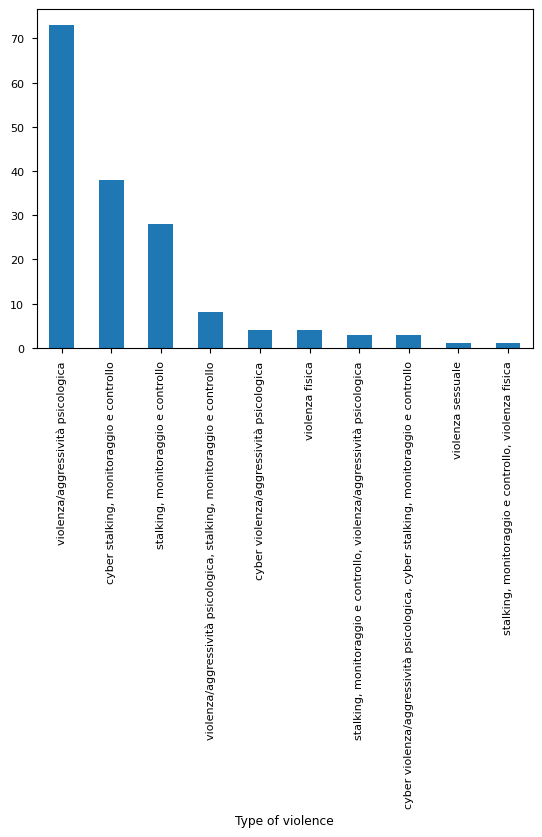

In [ ]:
df_violence = df[['sentence','Type of violence']]
df_violence['Type of violence'].value_counts().plot(kind="bar")

Before perform manually the oversampling, we try the classification with the unbalance dataset and we evaluate them

In [ ]:
classifier_violence = svm.LinearSVC()

pipeline_violence = Pipeline([("cleaner", predictors()),
 ('vectorizer', vector),
  ('classifier', classifier_violence)
  ])

#K-fold
kf = KFold(n_splits=10, random_state=42, shuffle=True)
fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df_violence['sentence'].to_numpy()
y = df_violence['Type of violence'].to_numpy()

for _ in tqdm(range(n_iteration)):
  for train_index, test_index in kf.split(X):
    pipeline_violence.fit(X[train_index], y[train_index])
    predicted = pipeline_violence.predict(X[test_index])

    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n======================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("========================================================================================================")

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Accuracy: 0.5687500000000001
P=0.33246825396825386, R=0.3554629629629631, F1 Macro=0.3292920804685513, F1 Micro=0.3292920804685513


<Axes: xlabel='Type of aggressive communication'>

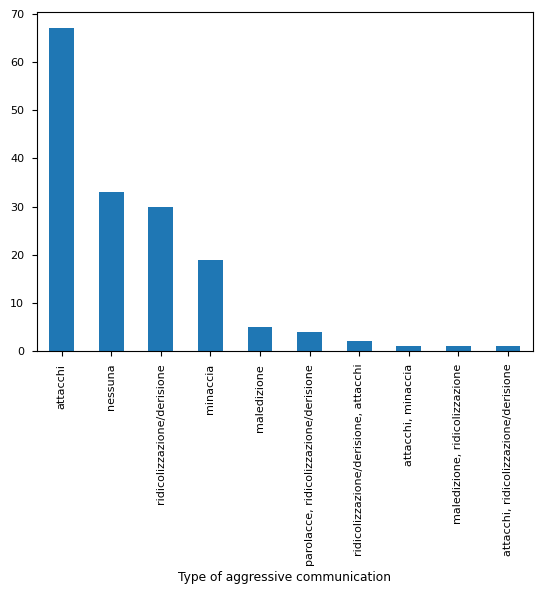

In [ ]:
df_comunication = df[['sentence','Type of aggressive communication']]
df_comunication['Type of aggressive communication'].value_counts().plot(kind="bar")

In [ ]:
classifier_comunication = svm.LinearSVC()

pipeline_comunication = Pipeline([("cleaner", predictors()),
 ('vectorizer', vector),
  ('classifier', classifier_comunication)
  ])

#K-fold
kf = KFold(n_splits=10, random_state=42, shuffle=True)
fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df['sentence'].to_numpy()
y = df['Type of aggressive communication'].to_numpy()

for _ in tqdm(range(n_iteration)):
  for train_index, test_index in kf.split(X):
    pipeline_comunication.fit(X[train_index], y[train_index])
    predicted = pipeline_comunication.predict(X[test_index])

    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n======================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("======================================================================================================")

100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Accuracy: 0.4591911764705883
P=0.32372077922077913, R=0.3182660533910531, F1 Macro=0.30035738846309384, F1 Micro=0.30035738846309384


## First classification
Now we upload the data augmented dataset for the first classification and we perform the classification

In [ ]:
with open('toxic_relationship_violence_dataset.csv', 'r', encoding='utf-8') as f:
    for i,line in enumerate(f.readlines()):
        if i == 0:
            df_violence = pd.DataFrame(columns=['sentence','Type of violence'])
        else:
          line = line.lower()
          row = line.strip().split(';')
          df_violence.loc[i] = row
df_violence.tail()

,sentence,Type of violence
574,non mi va bene che tu passi del tempo con i tu...,"stalking, monitoraggio e controllo"
575,la fidanzata del mio amico non le permette di ...,"stalking, monitoraggio e controllo"
576,"se esci, devi tornare a casa al mio stesso ora...","stalking, monitoraggio e controllo"
577,non voglio che tu frequenti i tuoi amici.,"stalking, monitoraggio e controllo"
578,il partner della mia amica non le lascia mette...,"stalking, monitoraggio e controllo"


<Axes: xlabel='Type of violence'>

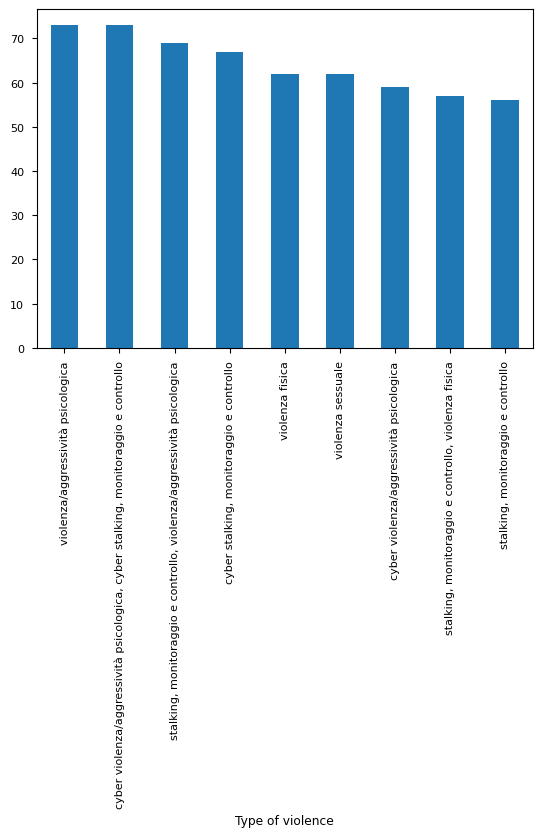

In [ ]:
df_violence['Type of violence'].value_counts().plot(kind="bar")

In [ ]:
df_violence['Type of violence'].value_counts()

Type of violence
violenza/aggressività psicologica                                                    73
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo    73
stalking, monitoraggio e controllo, violenza/aggressività psicologica                69
cyber stalking, monitoraggio e controllo                                             67
violenza fisica                                                                      62
violenza sessuale                                                                    62
cyber violenza/aggressività psicologica                                              59
stalking, monitoraggio e controllo, violenza fisica                                  57
stalking, monitoraggio e controllo                                                   56
Name: count, dtype: int64

### First model at low level
Let’s make a first classification to recognize the Type of violence, the dataset is already augmented, so we just perform the classification.

Considering that we haven't a lot of example, we perform the repeated stratified Kfold cross validation. We choose the stratified Kfold for aving the same number of class variable in test

We use two different classifier: a SVM and a Deep Learning and we take the most performing

#### SVM

In [ ]:
classifier_violence = svm.LinearSVC(loss='hinge')

pipeline_violence = Pipeline([("cleaner", predictors()),
 ('vectorizer', vector),
  ('classifier', classifier_violence)
  ])


fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df_violence['sentence'].to_numpy()
y = df_violence['Type of violence'].to_numpy()

# all the y predicted
y_pred = []
# all the ground truth of y
gt_y = []
for _ in tqdm(range(n_iteration)):
  #K-fold
  kf = StratifiedKFold(n_splits=10, shuffle=True)
  for train_index, test_index in kf.split(X,y):
    pipeline_violence.fit(X[train_index], y[train_index])
    predicted = pipeline_violence.predict(X[test_index])
    y_pred.extend(predicted)
    gt_y.extend(y[test_index])

    # Compute the evaluation metrics
    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n================================================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("=================================================================================================================================")
print(metrics.classification_report(gt_y, y_pred, digits=4, labels=classifier_violence.classes_))

100%|██████████| 10/10 [00:26<00:00,  2.67s/it]



Accuracy: 0.8766485178463396
P=0.8861776895943564, R=0.8782658730158733, F1 Macro=0.8741709804261402, F1 Micro=0.8741709804261402
                                                                                   precision    recall  f1-score   support

                                         cyber stalking, monitoraggio e controllo     0.8939    0.7925    0.8402       670
                                          cyber violenza/aggressività psicologica     0.8624    0.9881    0.9210       590
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo     0.9726    0.9726    0.9726       730
                                               stalking, monitoraggio e controllo     0.6857    0.6232    0.6529       560
                              stalking, monitoraggio e controllo, violenza fisica     0.9661    1.0000    0.9828       570
            stalking, monitoraggio e controllo, violenza/aggressività psicologica     0.8839    0.8275    0.8548       690
       

#### Deep Learning model

In [ ]:
X = df_violence['sentence'].to_numpy()
y = df_violence['Type of violence'].to_numpy()

vectorizer_violence = CountVectorizer()

X = vectorizer_violence.fit_transform(X)

# Number of features
input_dim = X.shape[1]
print("Number of features: ",input_dim)

# binarize labels
encoder_violence = LabelBinarizer()
encoder_violence.fit(y)
nc = encoder_violence.classes_.size
print("Number of classes: ",nc)

Number of features:  943
Number of classes:  9


In [ ]:
model_violence = Sequential()
model_violence.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
model_violence.add(layers.Dense(256, activation='relu'))
model_violence.add(layers.Dense(nc, activation='softmax'))

# compile the model
model_violence.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_violence.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               483328    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 616969 (2.35 MB)
Trainable params: 616969 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
clear_session() # Make sure to call clear_session() before you start training the model again

fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
y_gt = []
y_pred = []
#K-fold
kf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X,y):
  y_fold = encoder_violence.transform(y)
  X_f, X_test, y_f, y_test = X[train_index], X[test_index], y_fold[train_index], y_fold[test_index]

  X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1)

  model_violence.fit(X_train.toarray(), y_train, epochs=20, verbose=False, validation_data=(X_val.toarray(), y_val))
  pred = model_violence.predict(X_test.toarray(), verbose=False)

  pred = encoder_violence.inverse_transform(pred)
  y_test = encoder_violence.inverse_transform(y_test)

  y_gt.extend(y_test)
  y_pred.extend(pred)

  # Valutation metrics
  fmacro += metrics.f1_score(y_test, pred, average='macro')
  fmicro += metrics.f1_score(y_test, pred, average='micro')
  facc += metrics.accuracy_score(y_test, pred)
  fprecision += metrics.precision_score(y_test, pred, average='macro')
  frecall += metrics.recall_score(y_test, pred, average='macro')

print("\n========================================================================================================================================")
print("Accuracy:", facc/10)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/10, frecall/10, fmacro/10, fmicro/10))
print("========================================================================================================================================")
print(metrics.classification_report(y_gt, y_pred, digits=4))


Accuracy: 0.993103448275862
P=0.9952777777777777, R=0.9928571428571429, F1 Macro=0.9934134710605299, F1 Micro=0.9934134710605299
                                                                                   precision    recall  f1-score   support

                                         cyber stalking, monitoraggio e controllo     1.0000    0.9851    0.9925        67
                                          cyber violenza/aggressività psicologica     1.0000    1.0000    1.0000        59
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo     1.0000    1.0000    1.0000        73
                                               stalking, monitoraggio e controllo     1.0000    0.9821    0.9910        56
                              stalking, monitoraggio e controllo, violenza fisica     1.0000    1.0000    1.0000        57
            stalking, monitoraggio e controllo, violenza/aggressività psicologica     1.0000    0.9855    0.9927        69
        

## Second classification
We take the second increased dataset for the second classification and make the second classification for aggressive communication types

In [ ]:
with open('toxic_relationship_comunication_dataset.csv', 'r', encoding='utf-8') as f:
    for i,line in enumerate(f.readlines()):
        if i == 0:
            df_comunication = pd.DataFrame(columns=['sentence','Type of aggressive communication'])
        else:
          line = line.lower()
          row = line.strip().split(';')
          if row[0].startswith('"'):
            row[0] = row[0][1:-1].replace('""','"')

          df_comunication.loc[i] = row
df_comunication.tail()

,sentence,Type of aggressive communication
491,"mi fa notare ""chi ti accetterebbe con questa f...","maledizione, ridicolizzazione"
492,"mi dice sarcasticamente ""chi ti prenderà con q...","maledizione, ridicolizzazione"
493,"mi critica dicendo ""chi potrebbe mai desiderar...","maledizione, ridicolizzazione"
494,"mi deride chiedendomi ""chi mai potrà trovarti ...","maledizione, ridicolizzazione"
495,"mi sbeffeggia dicendo ""chi ti vorrà mai con qu...","maledizione, ridicolizzazione"


<Axes: xlabel='Type of aggressive communication'>

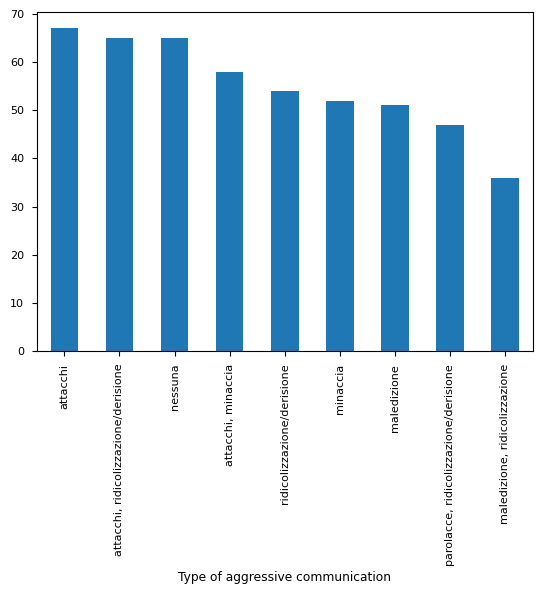

In [ ]:
df_comunication['Type of aggressive communication'].value_counts().plot(kind="bar")

In [ ]:
df_comunication['Type of aggressive communication'].value_counts()

Type of aggressive communication
attacchi                                 67
attacchi, ridicolizzazione/derisione     65
nessuna                                  65
attacchi, minaccia                       58
ridicolizzazione/derisione               54
minaccia                                 52
maledizione                              51
parolacce, ridicolizzazione/derisione    47
maledizione, ridicolizzazione            36
Name: count, dtype: int64

#### SVM

In [ ]:
classifier_comunication = neural_network.MLPClassifier(hidden_layer_sizes=(2048,),verbose=False,max_iter=50)

fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df_comunication['sentence'].to_numpy()
y = df_comunication['Type of aggressive communication'].to_numpy()

# all the y predicted
y_pred = []
# all the ground truth of y
gt_y = []
for _ in tqdm(range(n_iteration)):
  #K-fold
  kf = StratifiedKFold(n_splits=10, shuffle=True)
  for train_index, test_index in kf.split(X,y):
    X_fold = vector.fit_transform(X)

    classifier_comunication.fit(X_fold[train_index], y[train_index])
    predicted = classifier_comunication.predict(X_fold[test_index])

    y_pred.extend(predicted)
    gt_y.extend(y[test_index])

    # Valutation metrics
    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n==========================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("==========================================================================================================")
print(metrics.classification_report(gt_y, y_pred, digits=4))

100%|██████████| 10/10 [15:29<00:00, 92.92s/it]



Accuracy: 0.7603918367346939
P=0.8028152044034398, R=0.7715978835978838, F1 Macro=0.7590916166537377, F1 Micro=0.7590916166537377
                                       precision    recall  f1-score   support

                             attacchi     0.5184    0.2313    0.3199       670
                   attacchi, minaccia     0.9965    0.9845    0.9905       580
 attacchi, ridicolizzazione/derisione     0.9893    1.0000    0.9946       650
                          maledizione     0.8600    0.8314    0.8455       510
        maledizione, ridicolizzazione     0.8030    0.7472    0.7741       360
                             minaccia     0.3931    0.8731    0.5421       520
                              nessuna     0.8523    0.7015    0.7696       650
parolacce, ridicolizzazione/derisione     0.9203    0.9340    0.9271       470
           ridicolizzazione/derisione     0.8122    0.6407    0.7164       540

                             accuracy                         0.7604      495

#### Deep Learning model

In [ ]:
X = df_comunication['sentence'].to_numpy()
y = df_comunication['Type of aggressive communication'].to_numpy()

vectorizer_comunication = CountVectorizer()

X = vectorizer_comunication.fit_transform(X)

# Number of features
input_dim = X.shape[1]
print("Number of features: ",input_dim)

# binarize labels
encoder_comunication = LabelBinarizer()
#y = encoder.fit_transform(y)
encoder_comunication.fit(y)
nc = encoder_comunication.classes_.size
print("Number of classes: ",nc)

Number of features:  829
Number of classes:  9


In [ ]:
model_comunication = Sequential()
model_comunication.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
model_comunication.add(layers.Dense(256, activation='relu'))
model_comunication.add(layers.Dense(nc, activation='softmax'))

# compile the model
model_comunication.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_comunication.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               424960    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 558601 (2.13 MB)
Trainable params: 558601 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
clear_session() # Make sure to call clear_session() before you start training the model again

fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
gt_y = []
y_pred = []
#K-fold
kf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X,y):
  y_fold = encoder_comunication.transform(y)
  X_f, X_test, y_f, y_test = X[train_index], X[test_index], y_fold[train_index], y_fold[test_index]

  X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1)

  model_comunication.fit(X_train.toarray(), y_train, epochs=20, verbose=False, validation_data=(X_val.toarray(), y_val))
  pred = model_comunication.predict(X_test.toarray(), verbose=False)

  pred = encoder_comunication.inverse_transform(pred)
  y_test = encoder_comunication.inverse_transform(y_test)

  gt_y.extend(y_test)
  y_pred.extend(pred)

  # Valutation metrics
  fmacro += metrics.f1_score(y_test, pred, average='macro')
  fmicro += metrics.f1_score(y_test, pred, average='micro')
  facc += metrics.accuracy_score(y_test, pred)
  fprecision += metrics.precision_score(y_test, pred, average='macro')
  frecall += metrics.recall_score(y_test, pred, average='macro')

print("\n==========================================================================================================")
print("Accuracy:", facc/10)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/10, frecall/10, fmacro/10, fmicro/10))
print("==========================================================================================================")
print(metrics.classification_report(gt_y, y_pred, digits=4))


Accuracy: 0.984
P=0.9857407407407408, R=0.9861375661375661, F1 Macro=0.9849921683255015, F1 Micro=0.9849921683255015
                                       precision    recall  f1-score   support

                             attacchi     0.9844    0.9403    0.9618        67
                   attacchi, minaccia     1.0000    1.0000    1.0000        58
 attacchi, ridicolizzazione/derisione     1.0000    1.0000    1.0000        65
                          maledizione     0.9808    1.0000    0.9903        51
        maledizione, ridicolizzazione     1.0000    1.0000    1.0000        36
                             minaccia     1.0000    1.0000    1.0000        52
                              nessuna     0.9688    0.9538    0.9612        65
parolacce, ridicolizzazione/derisione     0.9787    0.9787    0.9787        47
           ridicolizzazione/derisione     0.9474    1.0000    0.9730        54

                             accuracy                         0.9838       495
           

# Second task, Generation
In this section, we had the two model for the classification of the new sentence and we use them for classify the sentence and perform the generation of explanation

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_key
)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
df = pd.read_csv('toxic_relationship_filtered_dataset.csv')
df.head()

,sentence,Type of violence,Type of aggressive communication,Description
0,Il mio ragazzo mi dice che sono una troia perc...,"Cyber Stalking, monitoraggio e controllo","Parolacce, Ridicolizzazione/derisione",Questa frase è un esempio di Cyber stalking in...
1,Il mio ragazzo dice che le donne non servono a...,Violenza/Aggressività psicologica,Ridicolizzazione/derisione,Questa frase è un esempio di violenza psicolog...
2,"Quando mi commuovo, la mia ragazza ride di me.",Violenza/Aggressività psicologica,Ridicolizzazione/derisione,Questa frase è un esempio di violenza psicolog...
3,"Guarda, quella è una puttana, l'altro giorno h...","Stalking, monitoraggio e controllo","Parolacce, Ridicolizzazione/derisione, Attacchi",Questa frase è un esempio di monitoraggio e co...
4,Ogni volta che qualcosa si rompe la lascio far...,Violenza/Aggressività psicologica,Ridicolizzazione/derisione,Questa frase è un esempio di violenza psicolog...


In [ ]:
prompt = """
Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.

In caps there's the rule that you must observe!

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [ ]:
instruction = """
Given a sentence, you will generate a NEW sentence that is SIMILAR to the input sentence but DIFFERENT.
The response must be ONLY the new sentence in Italian without explanation or additional content.
DO NOT REPEAT THE INPUT SENTENCE.

### Example:
Input: Il sole splende luminoso nel cielo
Response: Il sole brilla intensamente nel cielo

"""

In [ ]:
from transformers import TextStreamer

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

g_sentences = pd.DataFrame(columns=['sentence','Type of violence','Type of aggressive communication','Description'])
model.generation_config.pad_token_id = tokenizer.pad_token_id

for sentence, description in tqdm(df[['sentence','Description']].to_numpy()):

  inputs = tokenizer(
  [
      prompt.format(
          instruction, #Instruction
          sentence, # input
          "", # output - leave this blank for generation!
      )
  ], return_tensors = "pt").to("cuda")

  generated = model.generate(**inputs, max_new_tokens = 512,temperature=0.7)
  generated = tokenizer.decode(generated[0], skip_special_tokens=True)
  #generated = generated.split("Response:")[1]
  #generated = generated.replace("\n","")

  # Compute the first classification
  X = vectorizer_violence.transform([generated])
  y_violence = model_violence.predict(X.toarray(), verbose=False)
  y_violence = encoder_violence.inverse_transform(y_violence)

  # Compute the first classification
  X = vectorizer_comunication.transform([generated])
  y_comunication = model_comunication.predict(X.toarray(), verbose=False)
  y_comunication = encoder_comunication.inverse_transform(y_comunication)

  g_sentences.loc[len(g_sentences)] = {
      'sentence': generated,
      'Type of violence': y_violence[0],
      'Type of aggressive communication': y_comunication[0],
      'Description': description
      }

g_sentences

  7%|▋         | 12/163 [02:20<20:57,  8.33s/it]

In [ ]:
for i in g_sentences['sentence']:
  print(i)

### Parafrasare: Il mio ragazzo mi dice che sono una troia perché pubblico foto in bikini. ### Response:
### Parafrasare: Il mio ragazzo dice che le donne non servono a no niente. ### Response:
### Parafrasare: Quando mi commuovo, la mia ragazza ride di me. ### Response:
### Parafrasare: Guarda, quella è una puttana, l'altro giorno ha pubblicato una foto in bikini anche se è fidanzata. Non farti foto con quella schifosa. ### Response:
### Parafrasare: Ogni volta che qualcosa si rompe la lascio fare a mio marito,è il suo lavoro. ### Response:
### Parafrasare: Mi dice come devo vestirmi quando usciamo. ### Response:
### Parafrasare: Perchè sei online e non mi rispondi? ### Response:
### Parafrasare: Non farti fotografare con quella schifosa. ### Response:
### Parafrasare: Il mio ragazzo non sa fare le pulizie. ### Response:
### Parafrasare: Sono le donne che devono gestire la casa. ### Response:
### Parafrasare: Lo faccio innervosire e per questo qualche volta mi spinge o mi afferra fort